In [27]:
from torchvision.transforms import ToTensor
from torchvision import datasets
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import os
from utility.ffqd_mnist import FFQD_Dataset, label_for_id
from torch.utils.data import DataLoader
import torchvision.transforms as T

to_ten = ToTensor()
def image_and_pad (x):
    return nn.functional.pad(to_ten(x).view(1,28,28),(2,2,2,2))

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data/fashion",
    train=True,
    download=True,
    transform=image_and_pad,
)
train_dataloader = DataLoader(training_data, batch_size=64)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data/fashion",
    train=False,
    download=True,
    transform=image_and_pad,
)
test_dataloader = DataLoader(test_data, batch_size=64)

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

device = 'cpu'

In [11]:
training_data[1][0].shape

torch.Size([1, 32, 32])

In [13]:
# by: https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/
class LeNet(torch.nn.Module):
    def __init__(self, output_size=10):
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        # see: https://madebyollin.github.io/convnet-calculator/

        self.fc1 = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc3 = nn.Linear(84, output_size)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu1(out)
        out = self.fc3(out)
        return out
        # return y

In [14]:
model = LeNet()
optimizer = torch.optim.SGD(model.parameters(), lr=.01)
criterion = torch.nn.CrossEntropyLoss()

def reset_model():
    global model, optimizer
    model = LeNet()
    optimizer = torch.optim.SGD(model.parameters(), lr=.01)


In [22]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch_id, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # print(X.shape)
        # calculate loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)


        # print( y_pred.dtype, y_pred.shape)
        # print(loss)

        # backprop loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 100 == 0:
            print(f"({batch_id}) loss: {loss:>7}")



In [23]:
def test_one_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)
            pred_y = model(X)
            test_loss += loss_fn(pred_y, y).item()
            correct += (pred_y.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss, correct


In [26]:
reset_model()
# old_weights = torch.Tensor(np.array(model.get_parameter("fc.weight").detach().numpy())) # copy old weights
# old_weights = model.get_parameter("mlp_stack.0.weight").clone().detach()
for i in range(5):
    train_one_epoch(train_dataloader, model, criterion, optimizer)
    print(f"loss/acc: {test_one_epoch(test_dataloader, model, criterion)}")

(0) loss: 2.3192996978759766
(100) loss: 2.3099215030670166
(200) loss: 2.3040497303009033
(300) loss: 2.297100305557251
(400) loss: 2.2883822917938232
(500) loss: 2.2943615913391113
(600) loss: 2.283376932144165
(700) loss: 2.264726161956787
(800) loss: 2.2223854064941406
(900) loss: 1.8806426525115967
loss/acc: (1.5585138957211926, 0.4341)
(0) loss: 1.6625465154647827
(100) loss: 1.1531416177749634
(200) loss: 0.866998016834259
(300) loss: 0.9724318981170654
(400) loss: 0.8155137300491333
(500) loss: 0.8076281547546387
(600) loss: 0.8058091402053833
(700) loss: 0.7240474820137024
(800) loss: 0.7090227603912354
(900) loss: 0.7755886912345886
loss/acc: (0.7314060869490265, 0.7143)
(0) loss: 0.6962954998016357
(100) loss: 0.7158951759338379
(200) loss: 0.4999156892299652
(300) loss: 0.7586424946784973
(400) loss: 0.6571452617645264
(500) loss: 0.680047333240509
(600) loss: 0.6848768591880798
(700) loss: 0.5891278386116028
(800) loss: 0.6419174075126648
(900) loss: 0.6537161469459534
los

In [25]:
for name, par in model.named_parameters():
    print(name, par.shape)

layer1.0.weight torch.Size([6, 1, 5, 5])
layer1.0.bias torch.Size([6])
layer2.0.weight torch.Size([16, 6, 5, 5])
layer2.0.bias torch.Size([16])
fc1.weight torch.Size([120, 400])
fc1.bias torch.Size([120])
fc2.weight torch.Size([84, 120])
fc2.bias torch.Size([84])
fc3.weight torch.Size([10, 84])
fc3.bias torch.Size([10])


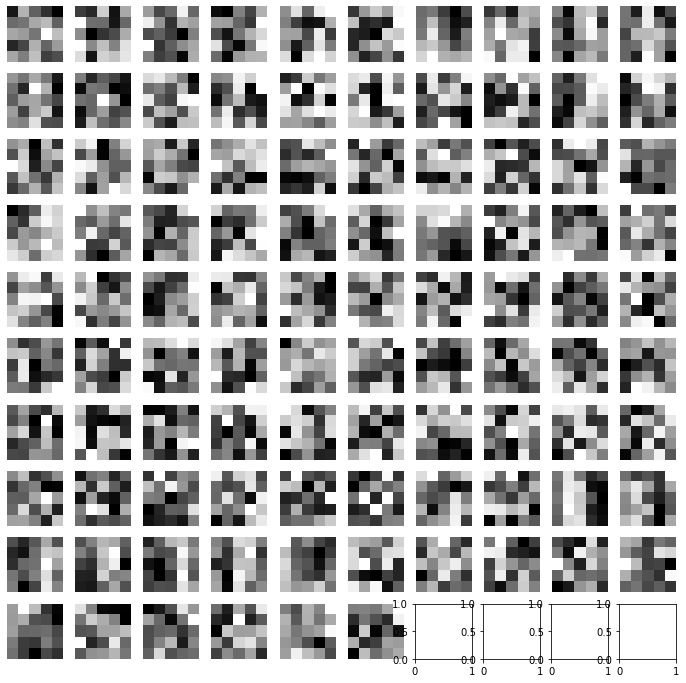

In [28]:
l0_weights = model.get_parameter('layer2.0.weight').detach()
# l0_weights_diff = l0_weights- old_weights
f, axs = plt.subplots(10,10,figsize=(12,12))
axs = axs.flatten()
for i in range(16):
    for ii in range(6):
        axs[i*6+ii].imshow(l0_weights[i,ii], cmap="gray")
        axs[i*6+ii].axis('off')

torch.Size([1, 1, 32, 32])
tensor(3) Dress


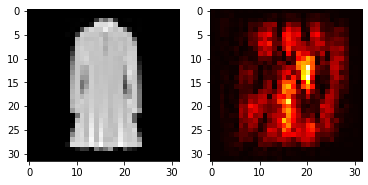

In [32]:
test_batch, test_batch_label = next(iter(test_dataloader))

img_index = 29
image = test_batch[img_index].unsqueeze(0)
label = test_batch_label[img_index].unsqueeze(0)

fig, axs = plt.subplots(1,2, figsize=(6,6))
axs= axs.flatten()

axs[0].imshow(image.view(32,32), cmap='gray')
model.eval()
x_in = image.clone().requires_grad_()
print(x_in.shape)
model.zero_grad()
pred = model(x_in)
# loss = criterion(pred, label)
# loss.backward()

pred_index = pred.argmax()

pred_max = pred[0, pred_index]
print(pred_index, classes[pred_index.item()])
pred_max.backward()

# # # saliency = nn.ReLU()(x_in.grad)
saliency = x_in.grad.detach().abs()[0]
# # # print(saliency.shape, saliency)
saliency = saliency.reshape(32, 32)
# #
axs[1].imshow(saliency, cmap="hot")


plt.show()

ground truth: 2 / Pullover
predcition: 2 / Pullover
torch.Size([1, 1, 32, 32])
attacked prediction: 6 / Shirt


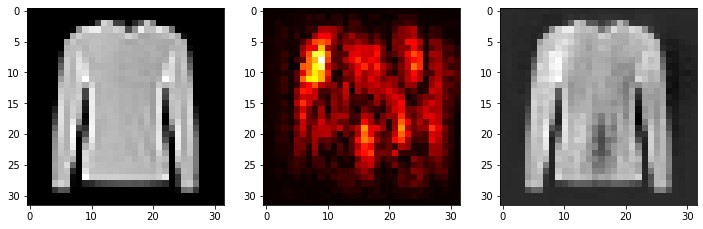

In [84]:
test_batch, test_batch_label = next(iter(test_dataloader))

item_id = 55 # 23, 55(rob), 34(rob)

image = test_batch[item_id].unsqueeze(0)
print(f"ground truth: {test_batch_label[item_id]} / {classes[test_batch_label[item_id]]}")

fig, axs = plt.subplots(1,3, figsize=(12,6))
axs= axs.flatten()

axs[0].imshow(image.view(32,32), cmap='gray')

x_in = image.clone().requires_grad_()
model.zero_grad()
pred = model(x_in)
pred_index = pred.argmax()
print(f"predcition: {pred_index.item()} / {classes[pred_index.item()]}")
pred_max = pred[0, pred_index]
# print(pred_max)
pred_max.backward()


saliency = x_in.grad.detach().abs()[0]
# print(saliency.shape, saliency)
saliency = saliency.reshape(32, 32)
axs[1].imshow(saliency, cmap="hot")

model.zero_grad()
pred = model(x_in)
pred_attack = pred[0, 1]
pred_attack.backward()
# print(x_in.grad)
x_attack = 0.1 *image + .1*(x_in.grad.detach()[0]) #nn.ReLU()

axs[2].imshow(x_attack.view(32,32), cmap='gray')
print(x_attack.shape)
pred = model(x_attack)
pred_index = pred.argmax()
print(f'attacked prediction: {pred_index.item()} / {classes[pred_index.item()]}')

plt.show()
